# Explore Gumbel Softmax

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt


<BarContainer object of 10 artists>

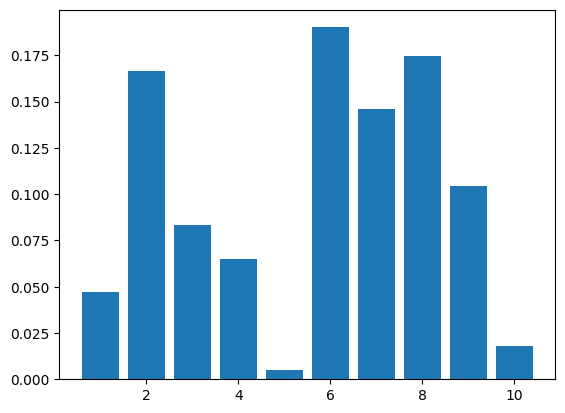

In [2]:
k = 10

pi = torch.randint(high=100, size=(k, ), dtype=torch.float)
pi = pi / pi.sum()

plt.bar(np.arange(k)+1, pi.numpy())

# Jang's Code in PyTorch

Eric Jang, one of the authors of [_Categorical Reparameterization with Gumbel-Softmax_](https://arxiv.org/abs/1611.01144), posted a Tensorflow based implementation on their github.

https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb

We will convert that to PyTorch.

For reference, here is Jang's code:

```python
def sample_gumbel(shape, eps=1e-20):
    U = tf.random_uniform(shape,minval=0,maxval=1)
    return -tf.log(-tf.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature): 
    y = logits + sample_gumbel(tf.shape(logits))
    return tf.nn.softmax( y / temperature)


def gumbel_softmax(logits, temperature, hard=False):
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y
```

In [3]:
from torch.distributions import Gumbel


def sample_gumbel(shape):
    """
    Sample from Gumbel(0, 1)
    """
    g = Gumbel(0, 1).sample(shape)
    return g


def gumbel_softmax_sample(logits, temperature):
    """
    Draw a sample from the Gumbel-Softmax distribution
    """
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature, hard=False):
    """
    Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
        logits: [batch_size, n_class] unnormalized log-probs
        temperature: non-negative scalar
        hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
        [batch_size, n_class] sample from the Gumbel-Softmax distribution.
        If hard=True, then the returned sample will be one-hot, otherwise it will
        be a probabilitiy distribution that sums to 1 across classes
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        # switch values to 0's and a 1
        y_hard = (y == y.max(dim=-1, keepdim=True)[0]).float()
        y = y_hard - y.detach() + y
    return y


# Graphing

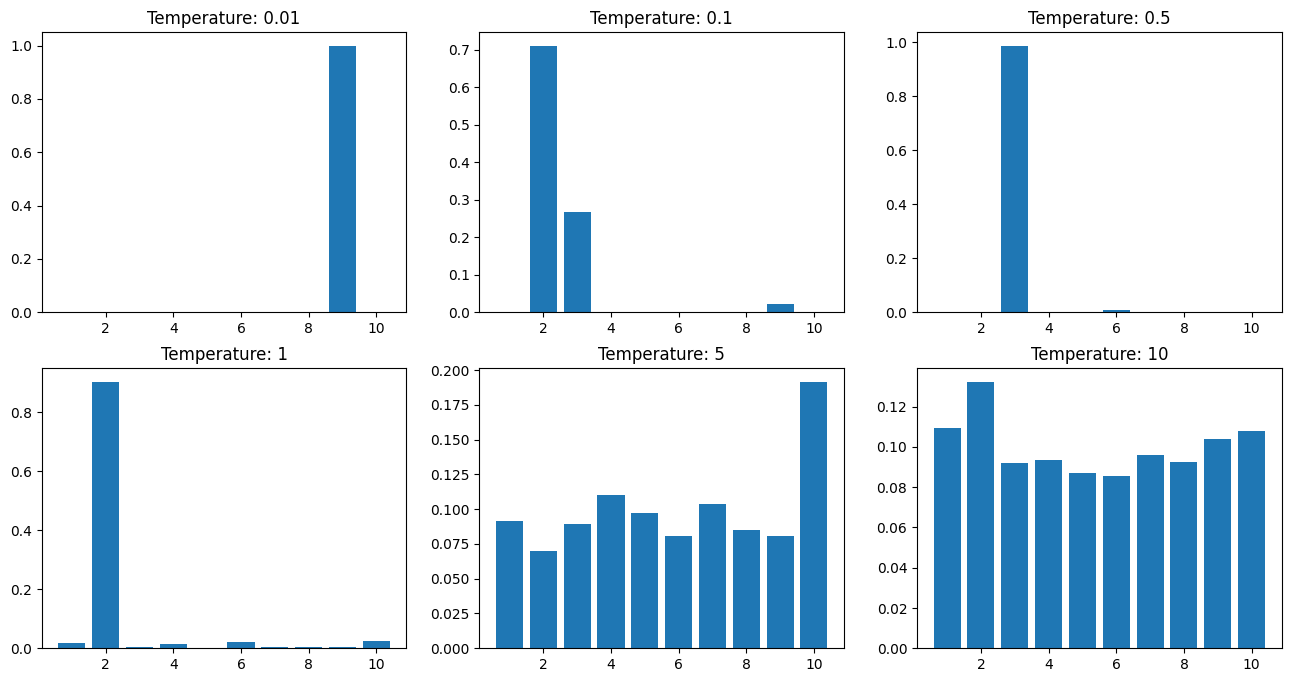

In [4]:
# Using Jang's Code

tau_vals = [0.01, 0.1, 0.5, 1, 5, 10]

plt.figure(figsize=(16,8))

for i in range(1, 7):
    z = gumbel_softmax(pi, temperature=tau_vals[i-1])
    plt.subplot(230+i)
    plt.bar(np.arange(k)+1, z.flatten().numpy())
    plt.title('Temperature: {}'.format(tau_vals[i-1]))


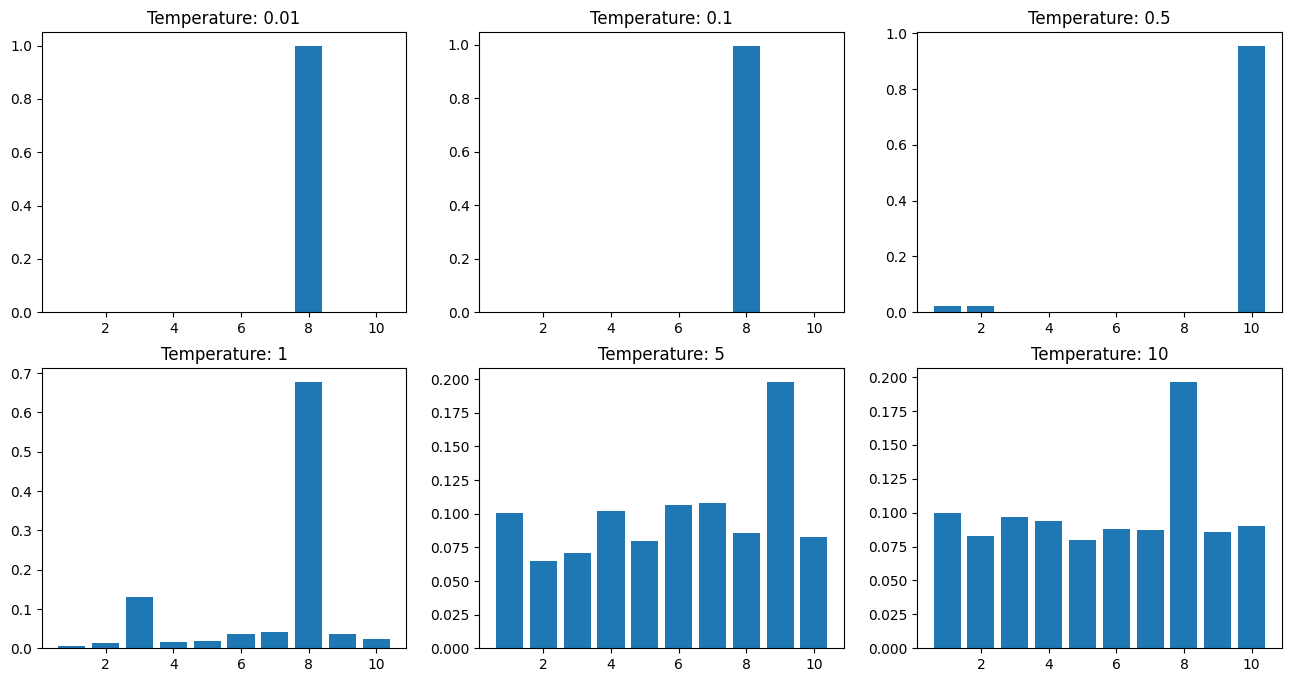

In [5]:
# Using PyTorch's implementation

tau_vals = [0.01, 0.1, 0.5, 1, 5, 10]

plt.figure(figsize=(16,8))

for i in range(1, 7):
    z = F.gumbel_softmax(pi, tau=tau_vals[i-1], hard=False)
    plt.subplot(230+i)
    plt.bar(np.arange(k)+1, z.flatten().numpy())
    plt.title('Temperature: {}'.format(tau_vals[i-1]))